# PPT 爬蟲

[GitHub｜jwlin/ptt-web-crawler](https://github.com/jwlin/ptt-web-crawler)

八卦版 27900 頁～39199 頁（1/1～4/15）

In [ ]:
from PttWebCrawler.crawler import *

In [ ]:
c = PttWebCrawler(as_lib=True)
for i in range(27900, 39200, 100):
    c.parse_articles(i, i+99, 'Gossiping')

# Read Json

In [1]:
import os
import json

## 篩選相關 article 轉存

In [6]:
import time
def date_converter(date = 'Wed Jan  1 15:00:29 2020'):
    strptime = time.strptime(date, '%a %b %d %H:%M:%S %Y')
    return str(strptime.tm_mon).zfill(2) + str(strptime.tm_mday).zfill(2) # '0101'

In [3]:
def with_keywords(s):
    keywords = ['WHO', '世界衛生組織', '世衛組織', '譚德塞', '譚塞德']
    return any(keyword in s for keyword in keywords)

In [9]:
WHO = [file for file in os.listdir('Gossiping') if file.endswith(".json")]
WHO.sort()

In [ ]:
All = 0
who = 0
All_percent_dict = {}
WHO_percent_dict = {}
Date = '0101'
for js in WHO:
    input_file = open ('Gossiping/'+js)
    json_array = json.load(input_file)
    for article in json_array['articles']:
        try:
            date = date_converter(date = article['date'])
            if date != Date:
                All_percent_dict[Date] = All
                WHO_percent_dict[Date] = who
                All, who = 0, 0
                Date = date
            All += 1
            if with_keywords(article['content']):
                who += 1
                filename = '%s %s.json' % (date, article['article_title'].replace(':','')[:50])
                try:
                    with open('WHO/'+filename, 'w', encoding='utf8') as f:
                        json.dump(article, f, ensure_ascii=False)
                except Exception as e:
                    filename = '%s %s.json' % (date, filterpunt(article['article_title'].replace(':','')[:50]))
                    with open('WHO/'+filename, 'w', encoding='utf8') as f:
                        json.dump(article, f, ensure_ascii=False)
        except Exception as e:
            pass
All_percent_dict[date] = All
WHO_percent_dict[date] = who

In [20]:
import pandas as pd
df = pd.DataFrame(columns=["All", "WHO"], index=pd.date_range(start='1/1/2020', end='4/15/2020'))
df['All'] = All_percent_dict.values()
df['WHO'] = WHO_percent_dict.values()
df['%'] = df['WHO']/df['All']*100
df.head()

,All,WHO,%
2020-01-01,550,3,0.545455
2020-01-02,1168,2,0.171233
2020-01-03,1147,1,0.087184
2020-01-04,1143,1,0.087489
2020-01-05,1232,0,0.000000


In [ ]:
df.to_csv('Result/%.csv')

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib.font_manager import FontProperties

plt.style.use('fivethirtyeight')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False
%config InlineBackend.figure_format = 'retina'

In [164]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

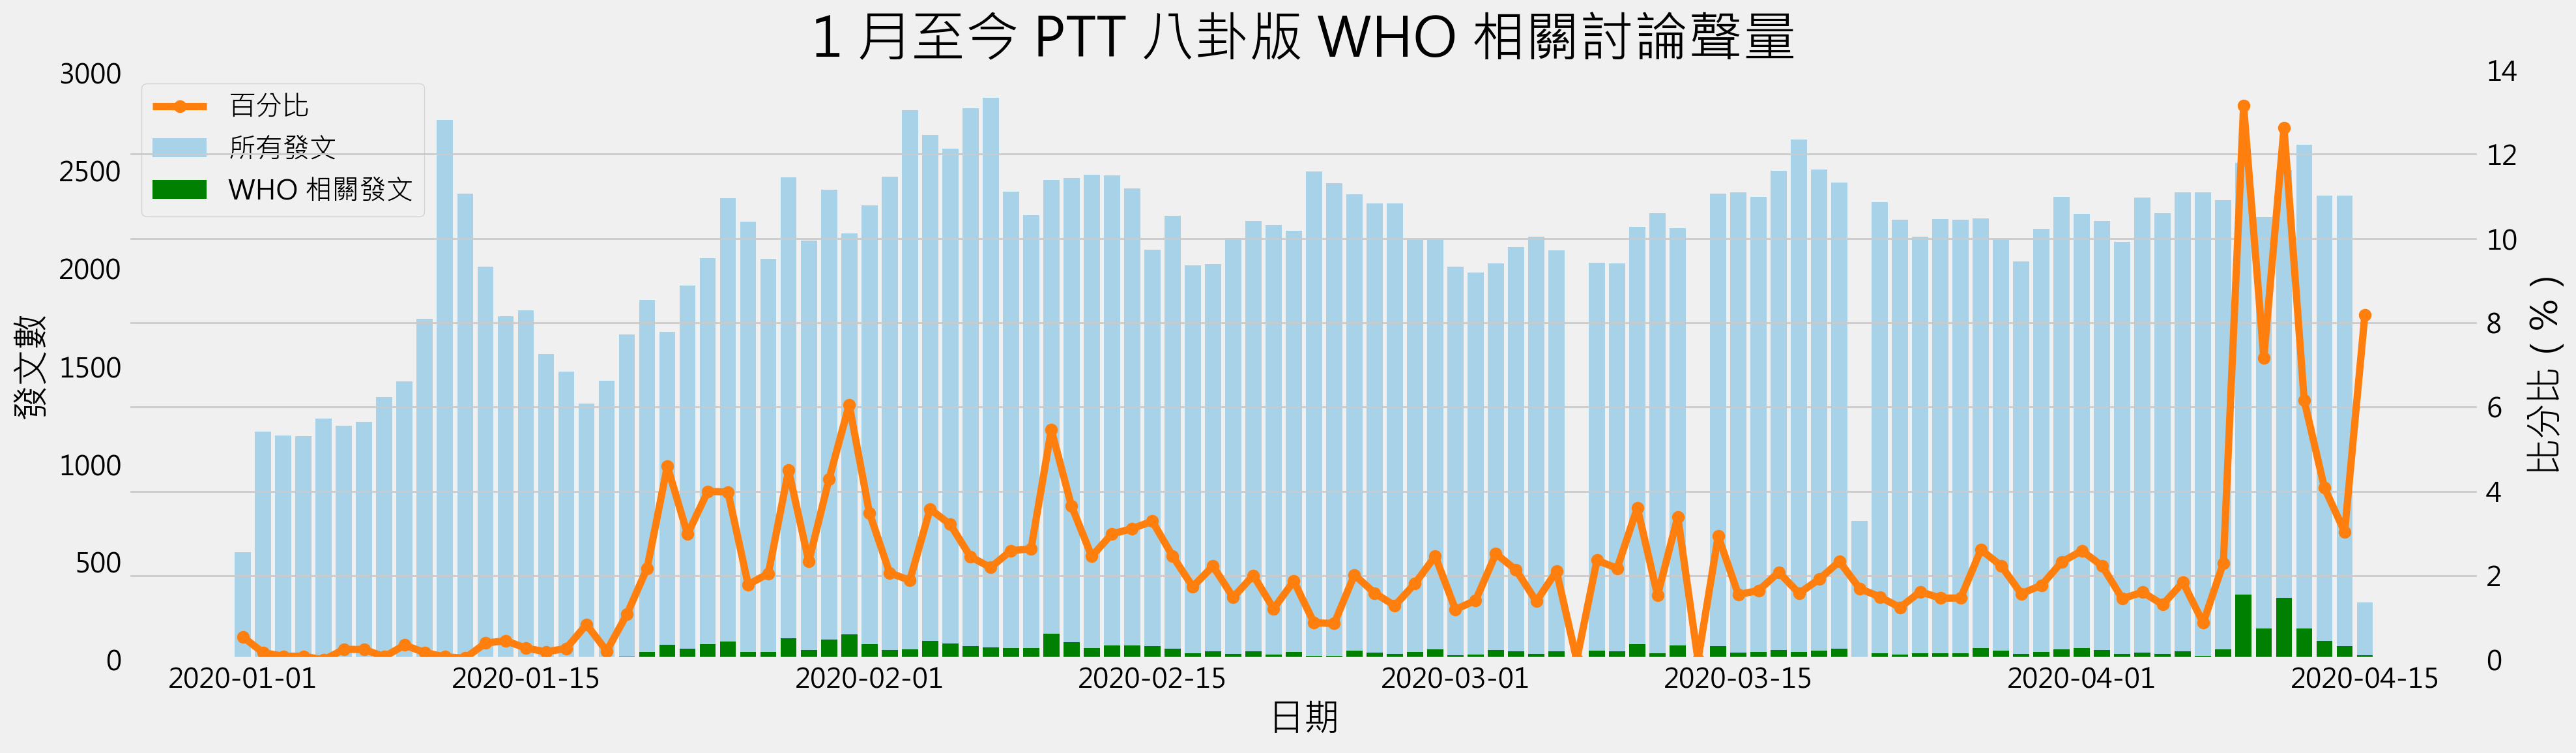

In [168]:
fig, ax = plt.subplots(figsize=(20,6))
plt.title('1 月至今 PTT 八卦版 WHO 相關討論聲量', fontsize=30)
plt.bar(df.index, df['All']-df['WHO'], bottom=df['WHO'], alpha=0.3, label='所有發文')
plt.bar(df.index, df['WHO'], color='g', label='WHO 相關發文')
plt.plot(df.index[4], df['%'][4], '-o', color=color[1], label='百分比')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('發文數', fontsize=20)
plt.xlabel('日期', fontsize=20)
plt.grid()
plt.legend(fontsize=15, loc=2)
plt.twinx()
plt.ylim([0,14])
plt.ylabel('比分比（%）', fontsize=20)
plt.plot(df.index, df['%'], '-o', color=color[1], label='百分比')
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Result/百分比.png', dpi=300)
plt.show()

In [139]:
df.to_csv('%.csv')

# jieba

In [7]:
import os
import jieba
import pickle
from collections import Counter
jieba.suggest_freq('世衛組織', True)
jieba.suggest_freq('世界衛生組織', True)
jieba.suggest_freq('譚德塞', True)

2

In [5]:
punct = set(u''':!),.:;?]}¢'"、。〉》」』】〕〗〞︰︱︳﹐､﹒
﹔﹕﹖﹗﹚﹜﹞！），．：；？｜/｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠
々‖•·ˇˉ―--′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻
︽︿﹁﹃﹙﹛﹝（｛“‘ -—_…''')
filterpunt = lambda s: ''.join(filter(lambda x: x not in punct, s))

In [ ]:
cont_counter = Counter()
mes_counter = Counter()
ng_cont = []
ng_mes = []
num_mes = 0
num_mes_words = 0
num_cont_words = 0
WHO_month = [file for file in os.listdir('WHO/1月') if file.endswith(".json")]

In [ ]:
for js in WHO_month:
    input_file = open ('WHO/1月/'+js)
    json_array = json.load(input_file)
    content = filterpunt(json_array['content'])
    count = Counter(jieba.cut(content))
    cont_counter += count
    num_cont_words += len(content)
    num_mes += len(json_array['messages'])
    if count['尼哥'] > 0:
        ng_cont.append({'author':json_array['author'], 'date':json_array['date'],
                        'article_title':json_array['article_title'], 'content':json_array['content'], 'url':json_array['url']})
    for mes in json_array['messages']:
        content = filterpunt(mes['push_content'])
        count = Counter(jieba.cut(content))
        mes_counter += count
        num_mes_words += len(content)
        if count['尼哥'] > 0:
            ng_mes.append({'push_userid':mes['push_userid'], 'date':json_array['date'],
                        'article_title':json_array['article_title'], 'push_content':mes['push_content'], 'url':json_array['url']})

In [ ]:
with open('Result/1月NGcont.json', 'w', encoding='utf8') as f:
    json.dump(ng_cont, f, ensure_ascii=False)
with open('Result/1月NGmes.json', 'w', encoding='utf8') as f:
    json.dump(ng_mes, f, ensure_ascii=False)
with open('Result/1月cont.pickle', 'wb') as outputfile:
    pickle.dump(cont_counter, outputfile)
with open('Result/1月mes.pickle', 'wb') as outputfile:
    pickle.dump(mes_counter, outputfile)

In [16]:
print('num_cont:', len(WHO_month))
print('num_cont_words:', num_cont_words)
print('num_mes:', num_mes)
print('num_mes_words:', num_mes_words)

num_cont: 802
num_cont_words: 613179
num_mes: 74522
num_mes_words: 7072


In [62]:
cont_counter['譚德塞'], cont_counter['WHO'], cont_counter['尼哥']

(776, 2335, 25)

In [63]:
mes_counter['譚德塞'], mes_counter['WHO'], mes_counter['尼哥']

(141, 2341, 820)

# 統計相關討論度

In [2]:
import pickle
from collections import Counter

In [3]:
def Ignore(cont, most=15):
    ignore = {'的','在','是','有','了','也','都','人','對','說','就','不','我','你',
              '日','1','於','月','被','和','沒','來','但','要','會','我們','表示',
              '為','與','到','年','啊','嗎','好','去','啦','跟','吧','真的','自己',
              '就是','不是','很','不要','可以','又','才','喔','他','什麼','2','='
              '或','3','4','後','上'}
    for x in ignore:
        del cont[x]
    return cont.most_common(most)

In [4]:
def plot(most, name='1 月份與 WHO 相關文章的詞頻統計', save=False):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(25,10))
    plt.title(name, fontsize=35)
    rect = plt.bar(*zip(*most))
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x()+rect.get_width()/2, height+50.0, "%s" % int(height), fontsize=20, 
                     horizontalalignment='center')   
    autolabel(rect)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.ylabel('出現次數', fontsize=25)
    plt.tight_layout()
    if save:
        plt.savefig(('Result/%s.png'%name).replace(' ',''), dpi=300)
    plt.show()

In [17]:
with open('Result/1月cont.pickle', 'rb') as inputfile:
    cont = pickle.load(inputfile)
with open('Result/1月mes.pickle', 'rb') as inputfile:
    mes = pickle.load(inputfile)

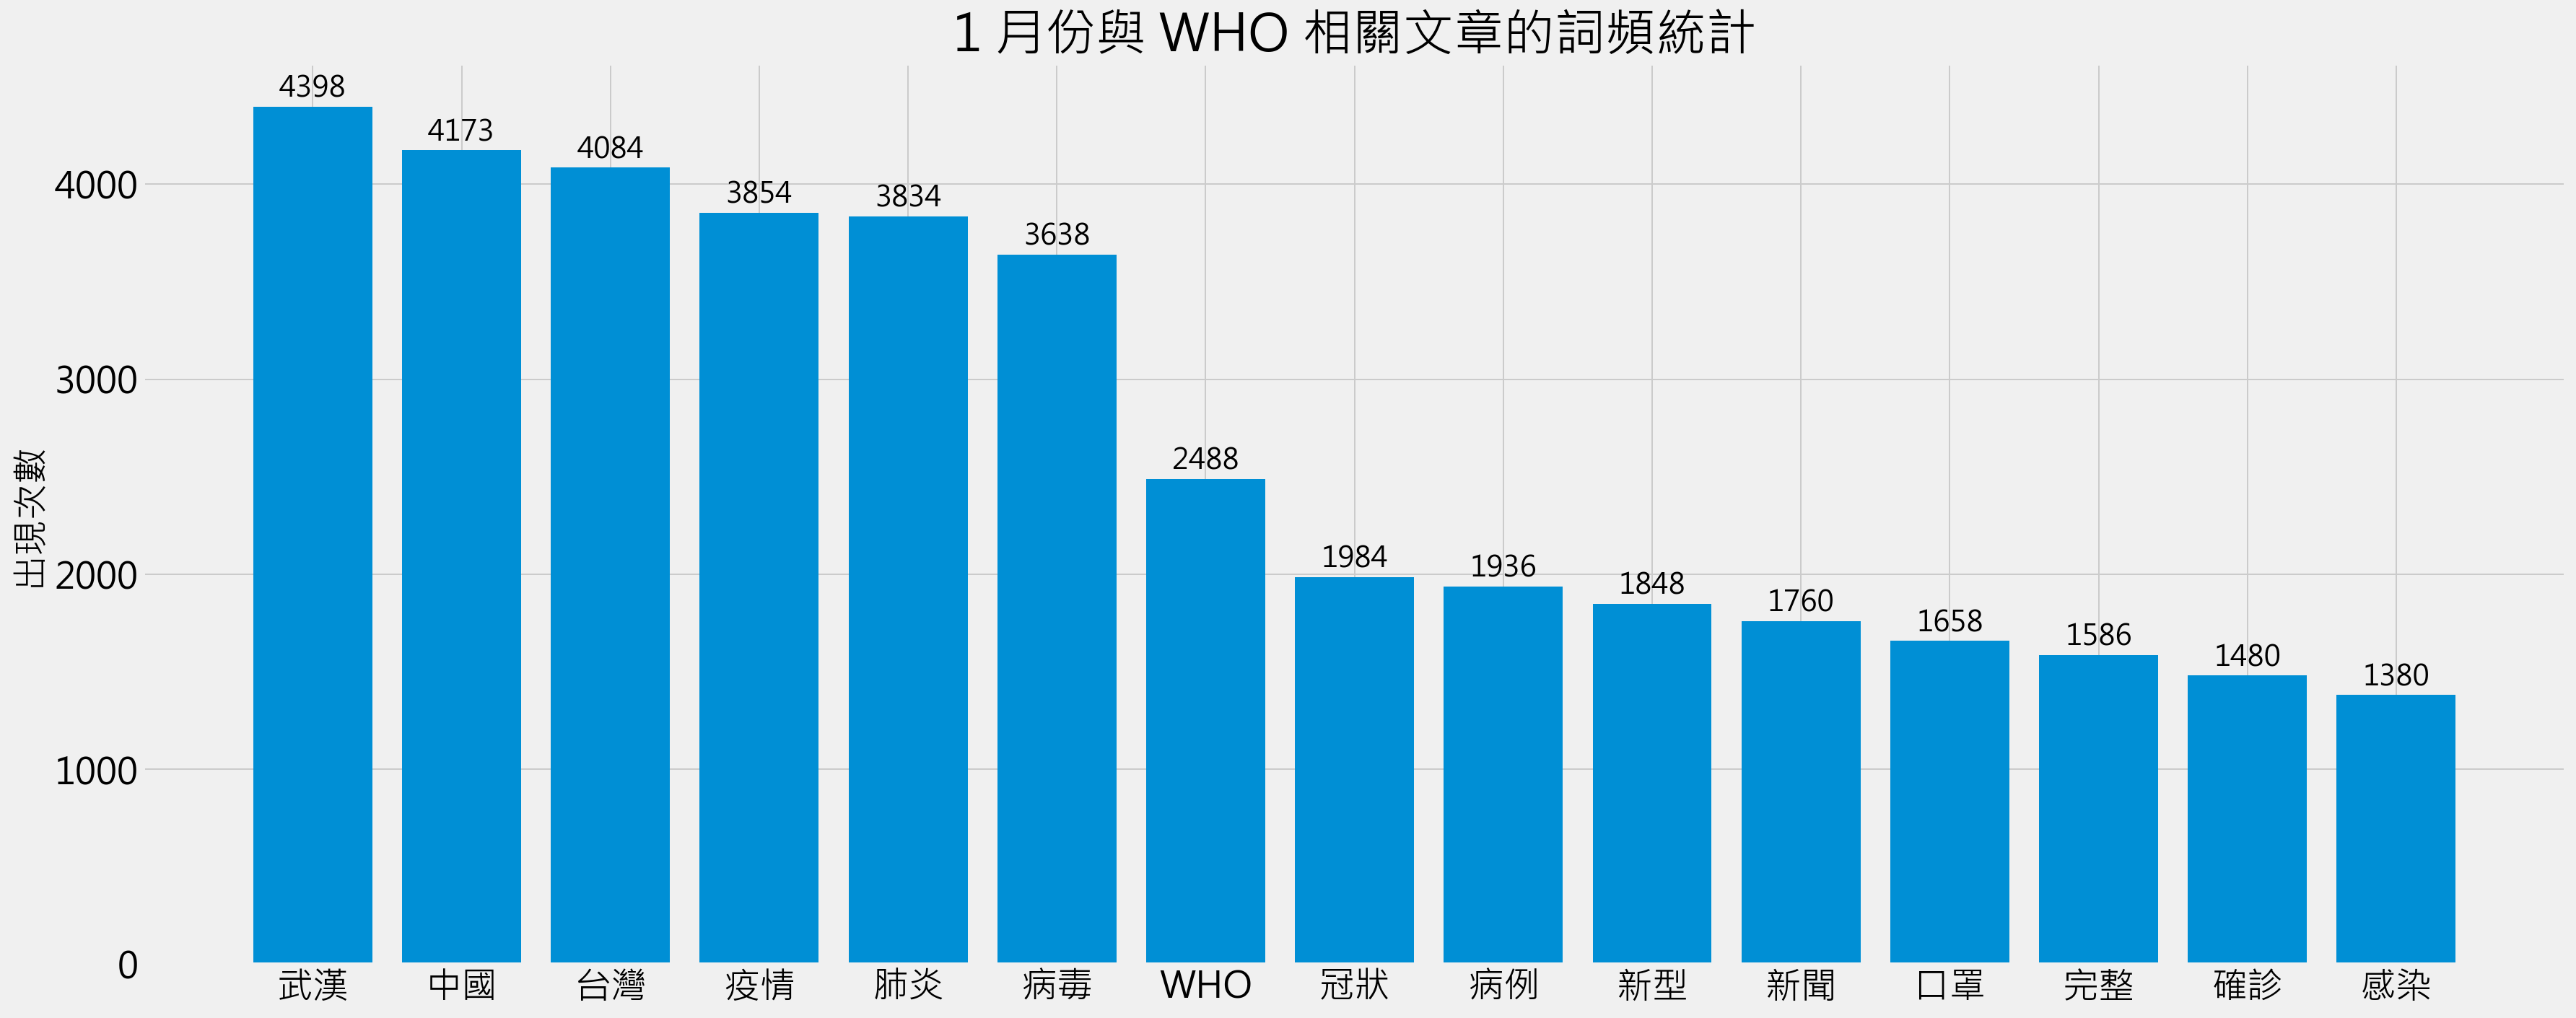

In [18]:
plot(Ignore(cont, most=15), name='1 月份與 WHO 相關文章的詞頻統計', save=False)

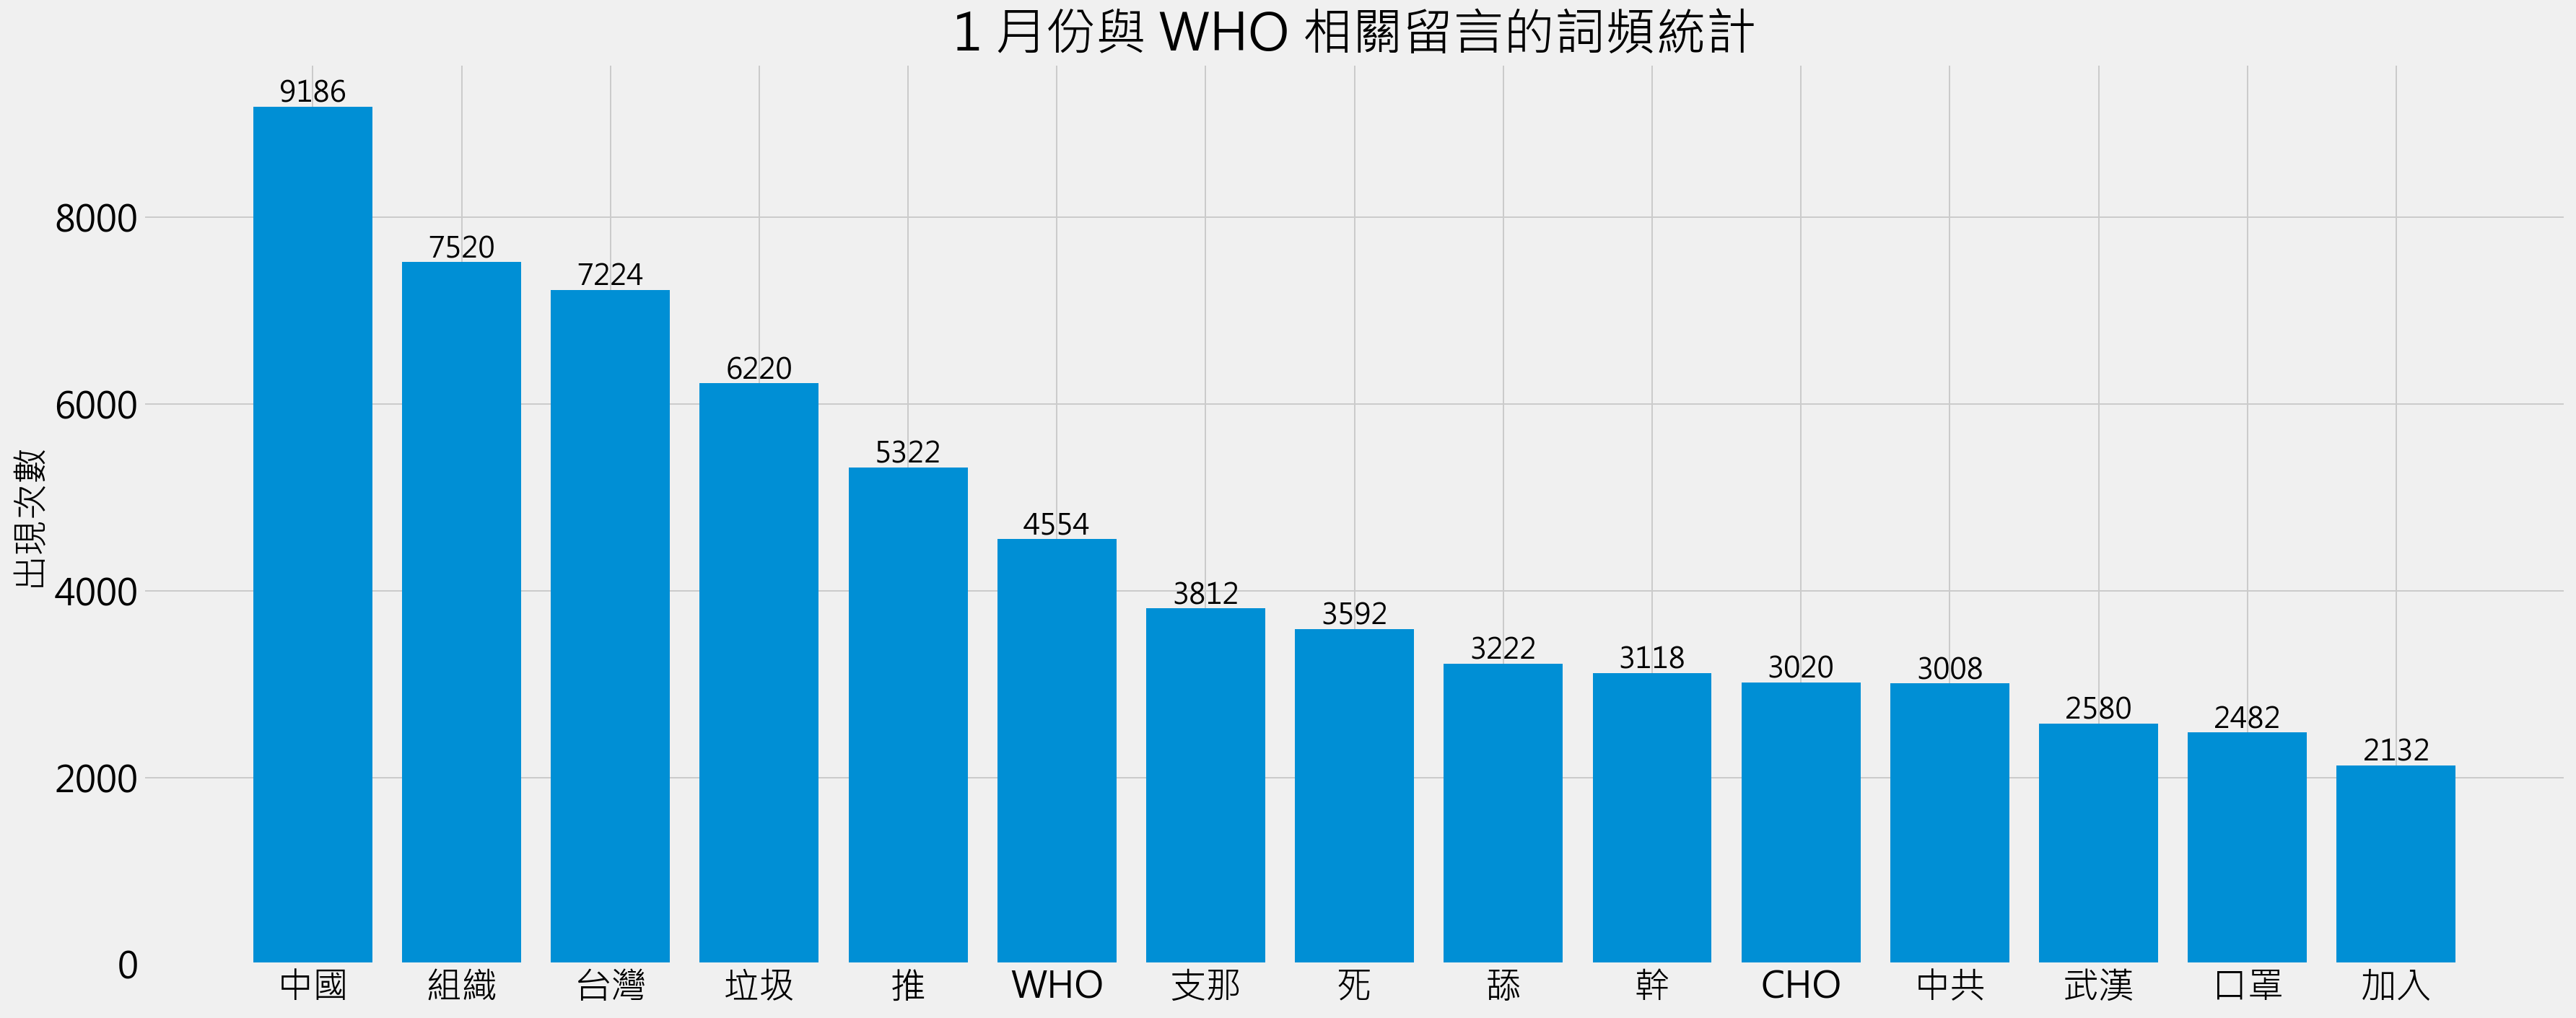

In [20]:
plot(Ignore(mes, most=15), name='1 月份與 WHO 相關留言的詞頻統計', save=False)

# 歧視性言論

In [12]:
import json
import time
import datetime
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib.font_manager import FontProperties

plt.style.use('fivethirtyeight')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
plt.rcParams["axes.unicode_minus"] = False
%config InlineBackend.figure_format = 'retina'

In [28]:
def date_converter(date = 'Wed Jan  1 15:00:29 2020'):
    strptime = time.strptime(date, '%a %b %d %H:%M:%S %Y')
    return str(strptime.tm_mon).zfill(2) + str(strptime.tm_mday).zfill(2) # '0101'

In [2]:
input_file = open ('Result/1月NGcont.json')
json_array = json.load(input_file)

In [24]:
def ng_cont(file='Result/1月NGcont.json', name_dict = {}, url_dict = {}):
    input_file = open (file)
    json_array = json.load(input_file)
    for i in json_array:
        if i['author'] in name_dict:
            name_dict[i['author']] += 1
        else:
            name_dict[i['author']] = 1
        url_dict[i['date']] = (i['article_title'], i['url'])
    return len(json_array), name_dict, url_dict

In [44]:
def ng_mes(file='Result/1月NGmes.json', name_dict = {}, url_dict = {}):
    input_file = open (file)
    json_array = json.load(input_file)
    for i in json_array:
        if i['push_userid'] in name_dict:
            name_dict[i['push_userid']] += 1
        else:
            name_dict[i['push_userid']] = 1
        url_dict[i['date']] = (i['push_userid'], i['push_content'], i['url'])
    return len(json_array), name_dict, url_dict

In [51]:
cont = []
name_dict, url_dict = {}, {}
for i in range(1,5):
    n , name_dict, url_dict = ng_cont(file='Result/%s月NGcont.json'%i, name_dict=name_dict, url_dict=url_dict)
    cont.append(n)

In [ ]:
url = []
for i in url_dict:
    url.append('[%s %s](%s)'%(date_converter(i), url_dict[i][0], url_dict[i][1]))
url.sort()
for i in url:
    print(i)

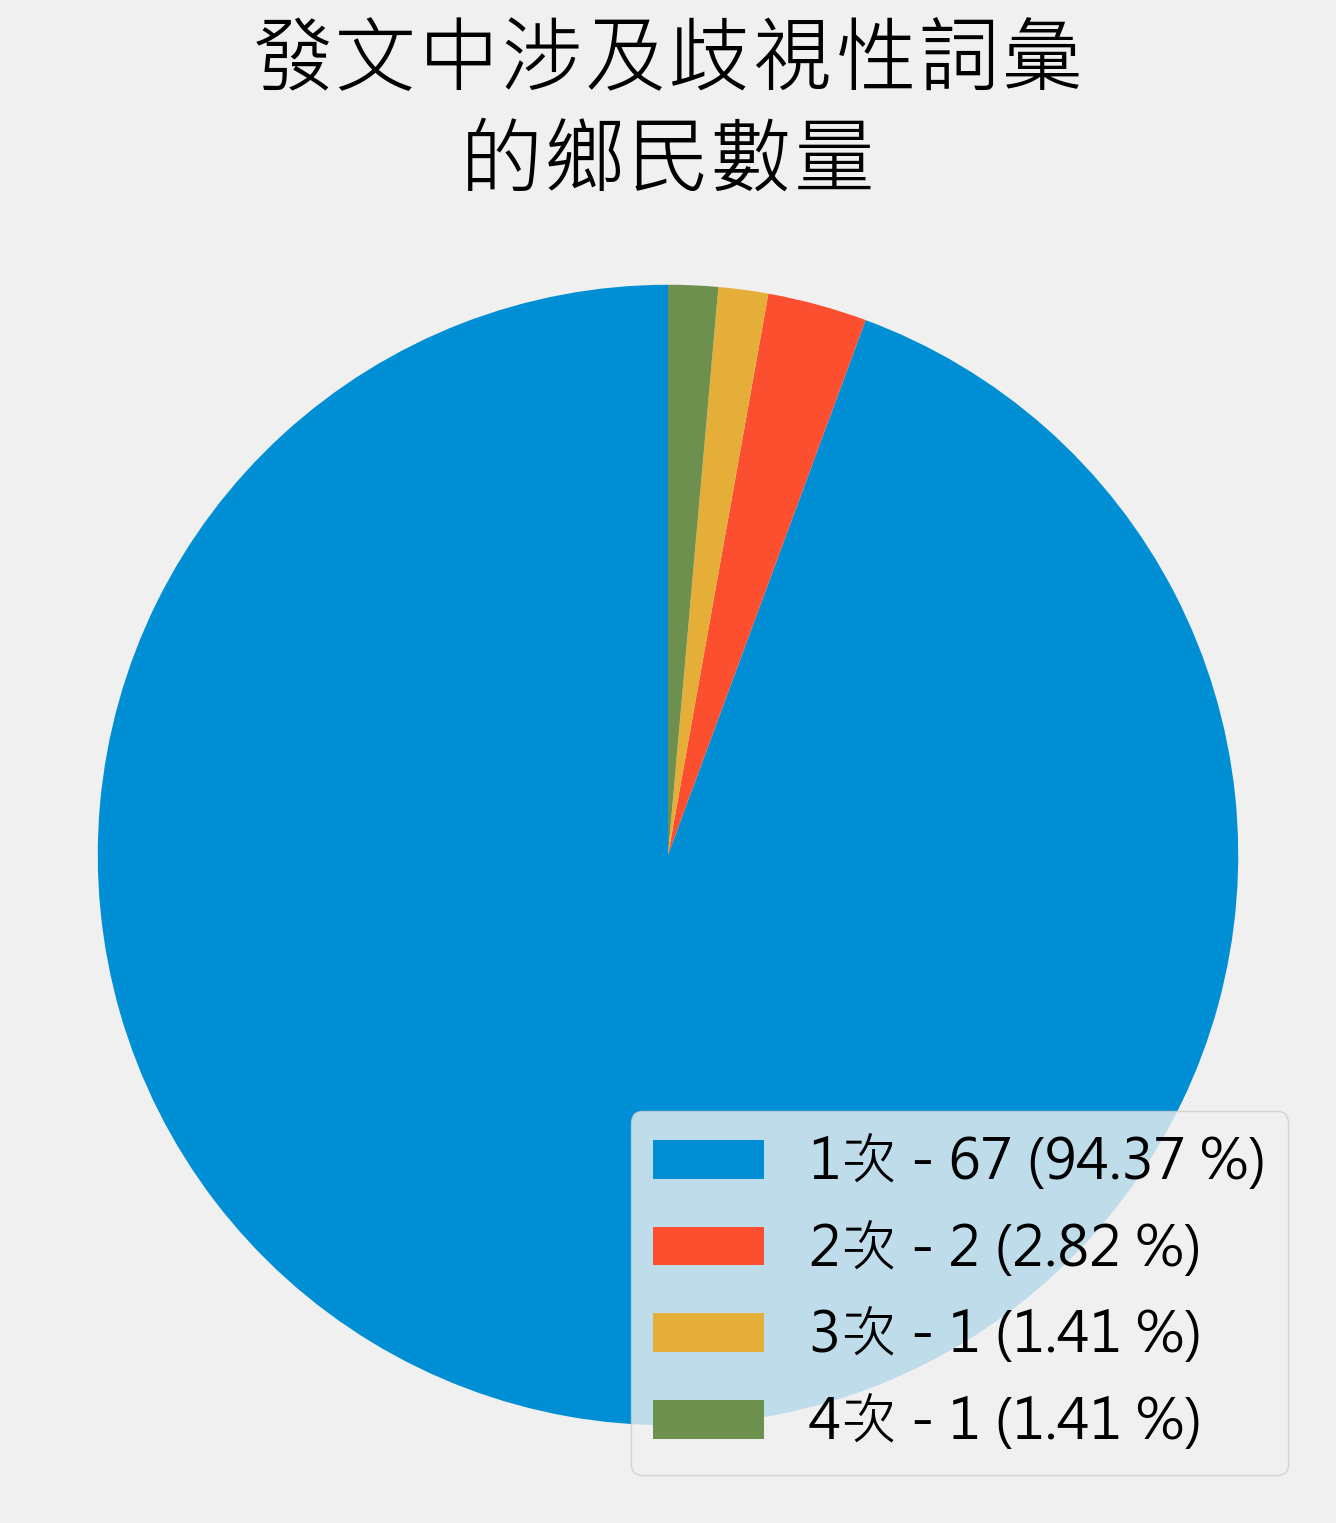

In [53]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 8))
data = Counter(name_dict.values())
x = sorted(data)
y = np.array([data[i] for i in x])
porcent = 100.*y/y.sum()
patches, texts = plt.pie(y, startangle=90, radius=1.1)
labels = ['{0}次 - {1} ({2:1.2f} %)'.format(i,j,k) for i,j,k in zip(x, y, porcent)]

plt.legend(patches, labels, loc='lower right', fontsize=20)
plt.title('發文中涉及歧視性詞彙\n的鄉民數量', fontsize=30)
plt.savefig('Result/發文中涉及歧視性詞彙的鄉民數量.png', bbox_inches='tight', dpi=300)
plt.show()

In [57]:
mes = []
name_dict, url_dict = {}, {}
for i in range(1,5):
    n , name_dict, url_dict = ng_mes(file='Result/%s月NGmes.json'%i, name_dict=name_dict, url_dict=url_dict)
    mes.append(n)

In [ ]:
url = []
for i in url_dict:
    url.append('[%s %s：%s](%s)'%(date_converter(i), url_dict[i][0], url_dict[i][1], url_dict[i][2]))
url.sort()
for i in url:
    print(i)

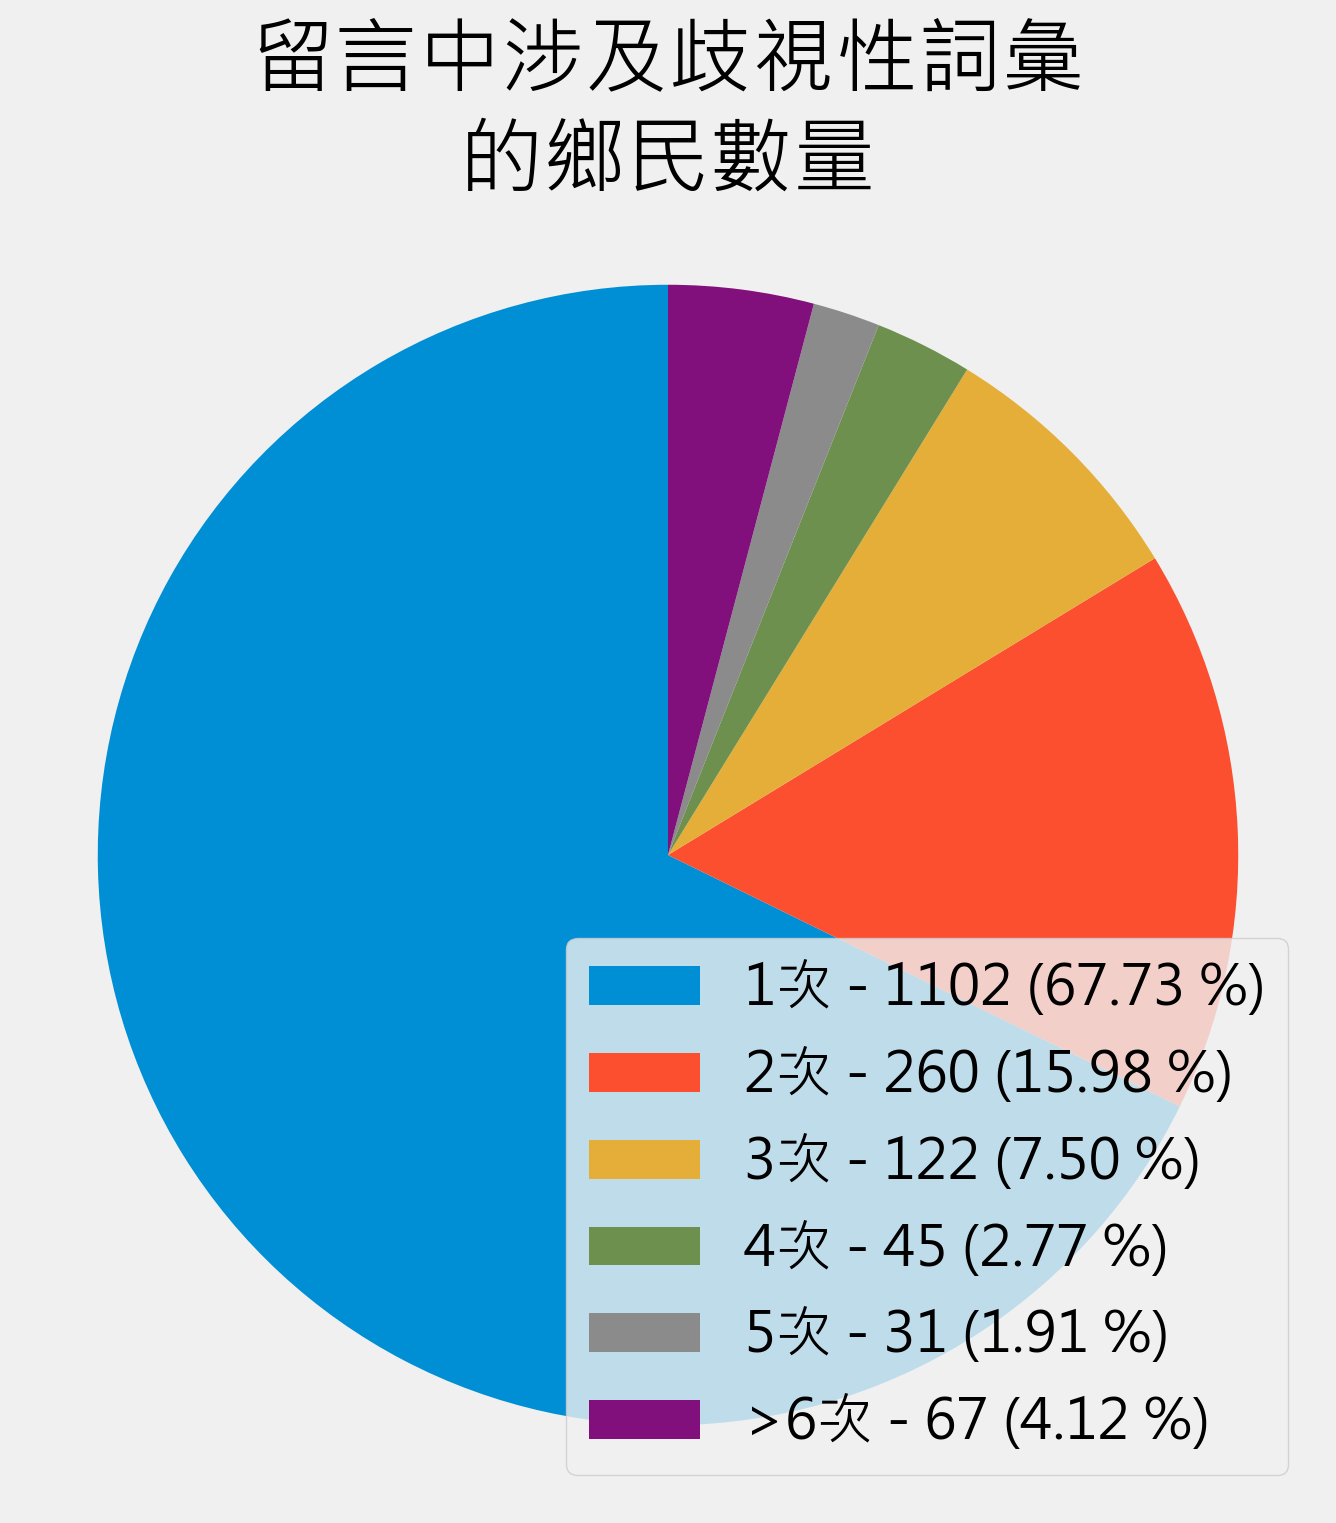

In [67]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 8))
data = Counter(name_dict.values())
x = sorted(data)[:5] + ['>6']
y = np.array([data[i] for i in sorted(data)[:5]] + [sum([data[i] for i in sorted(data)[5:]])])
porcent = 100.*y/y.sum()
patches, texts = plt.pie(y, startangle=90, radius=1.1)
labels = ['{0}次 - {1} ({2:1.2f} %)'.format(i,j,k) for i,j,k in zip(x, y, porcent)]

plt.legend(patches, labels, loc='lower right', fontsize=20)
plt.title('留言中涉及歧視性詞彙\n的鄉民數量', fontsize=30)
plt.savefig('Result/留言中涉及歧視性詞彙的鄉民數量.png', bbox_inches='tight', dpi=300)
plt.show()

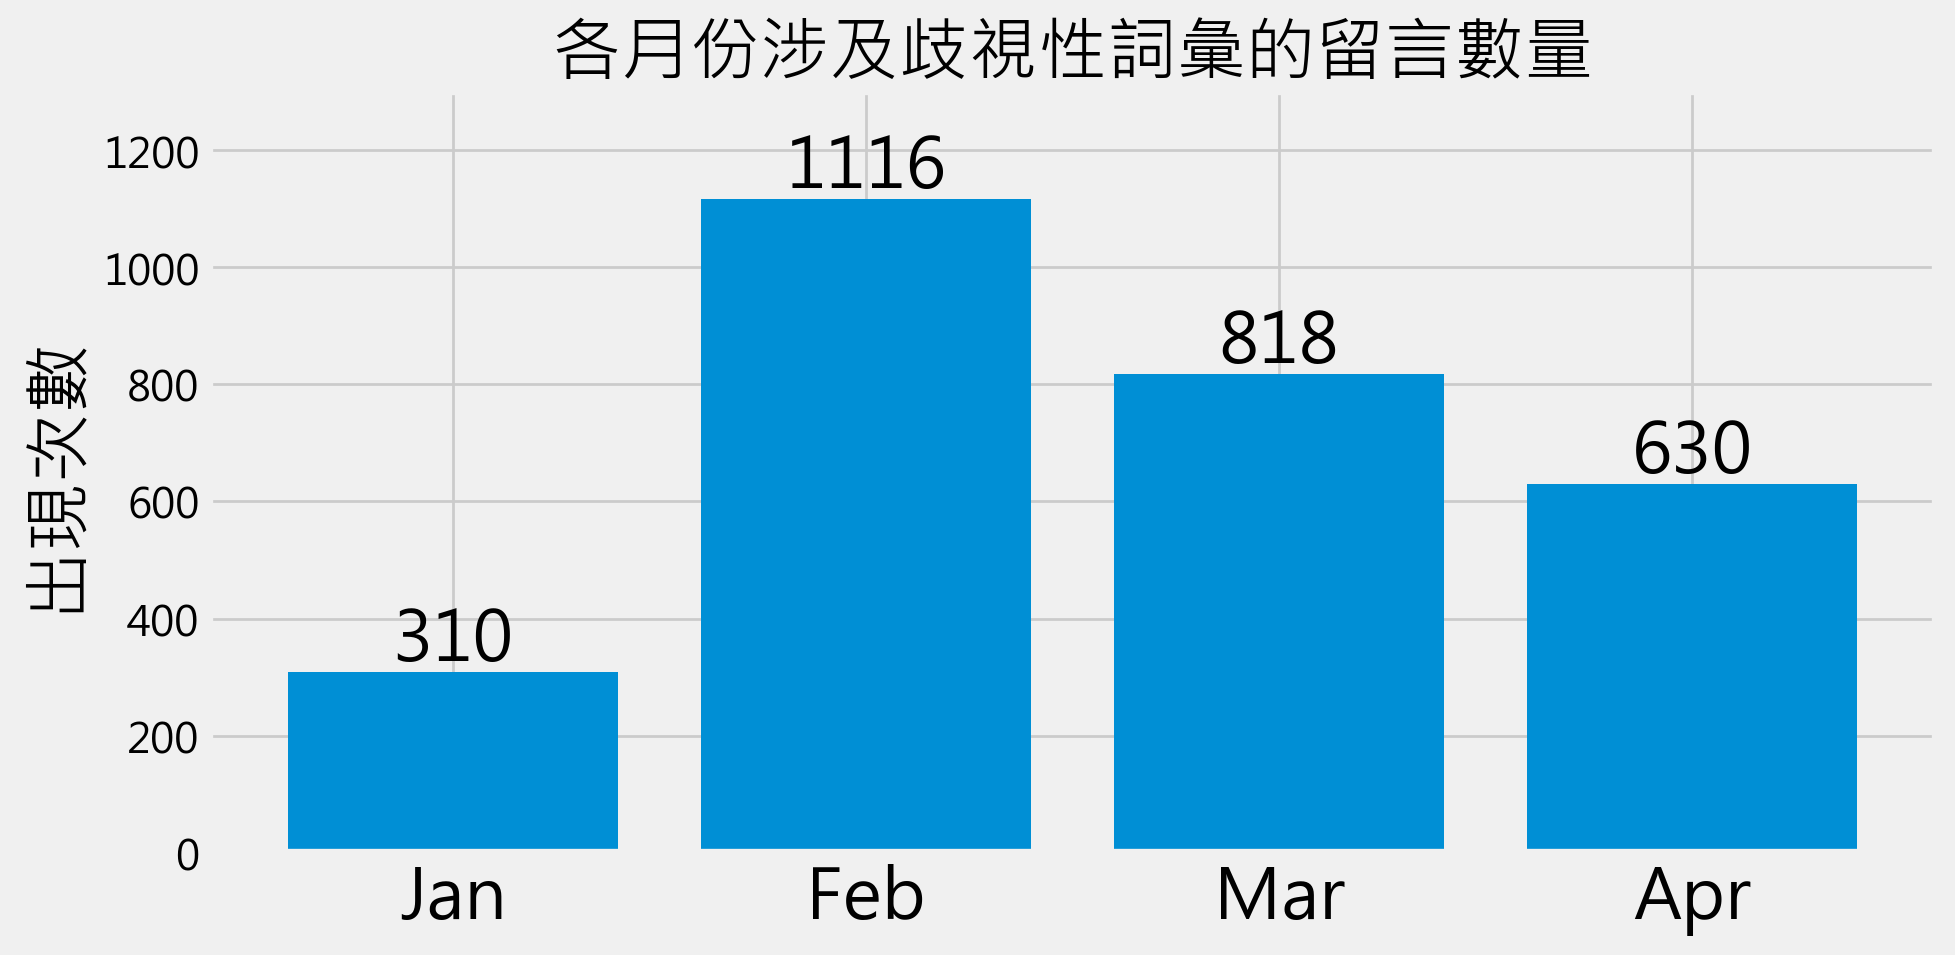

In [71]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
plt.title("各月份涉及歧視性詞彙的留言數量", fontsize=25)
rect = plt.bar(['Jan', 'Feb', 'Mar', 'Apr'], mes)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2, height+20.0, "%s" % int(height), fontsize=25, 
                 horizontalalignment='center')   
autolabel(rect)
plt.xticks(size=25)
plt.yticks(size=15)
plt.ylim([0, 1300])
plt.ylabel('出現次數', fontsize=25)
plt.tight_layout()
plt.savefig('Result/%s.png'%"各月份涉及歧視性詞彙的留言數量", dpi=300)
plt.show()

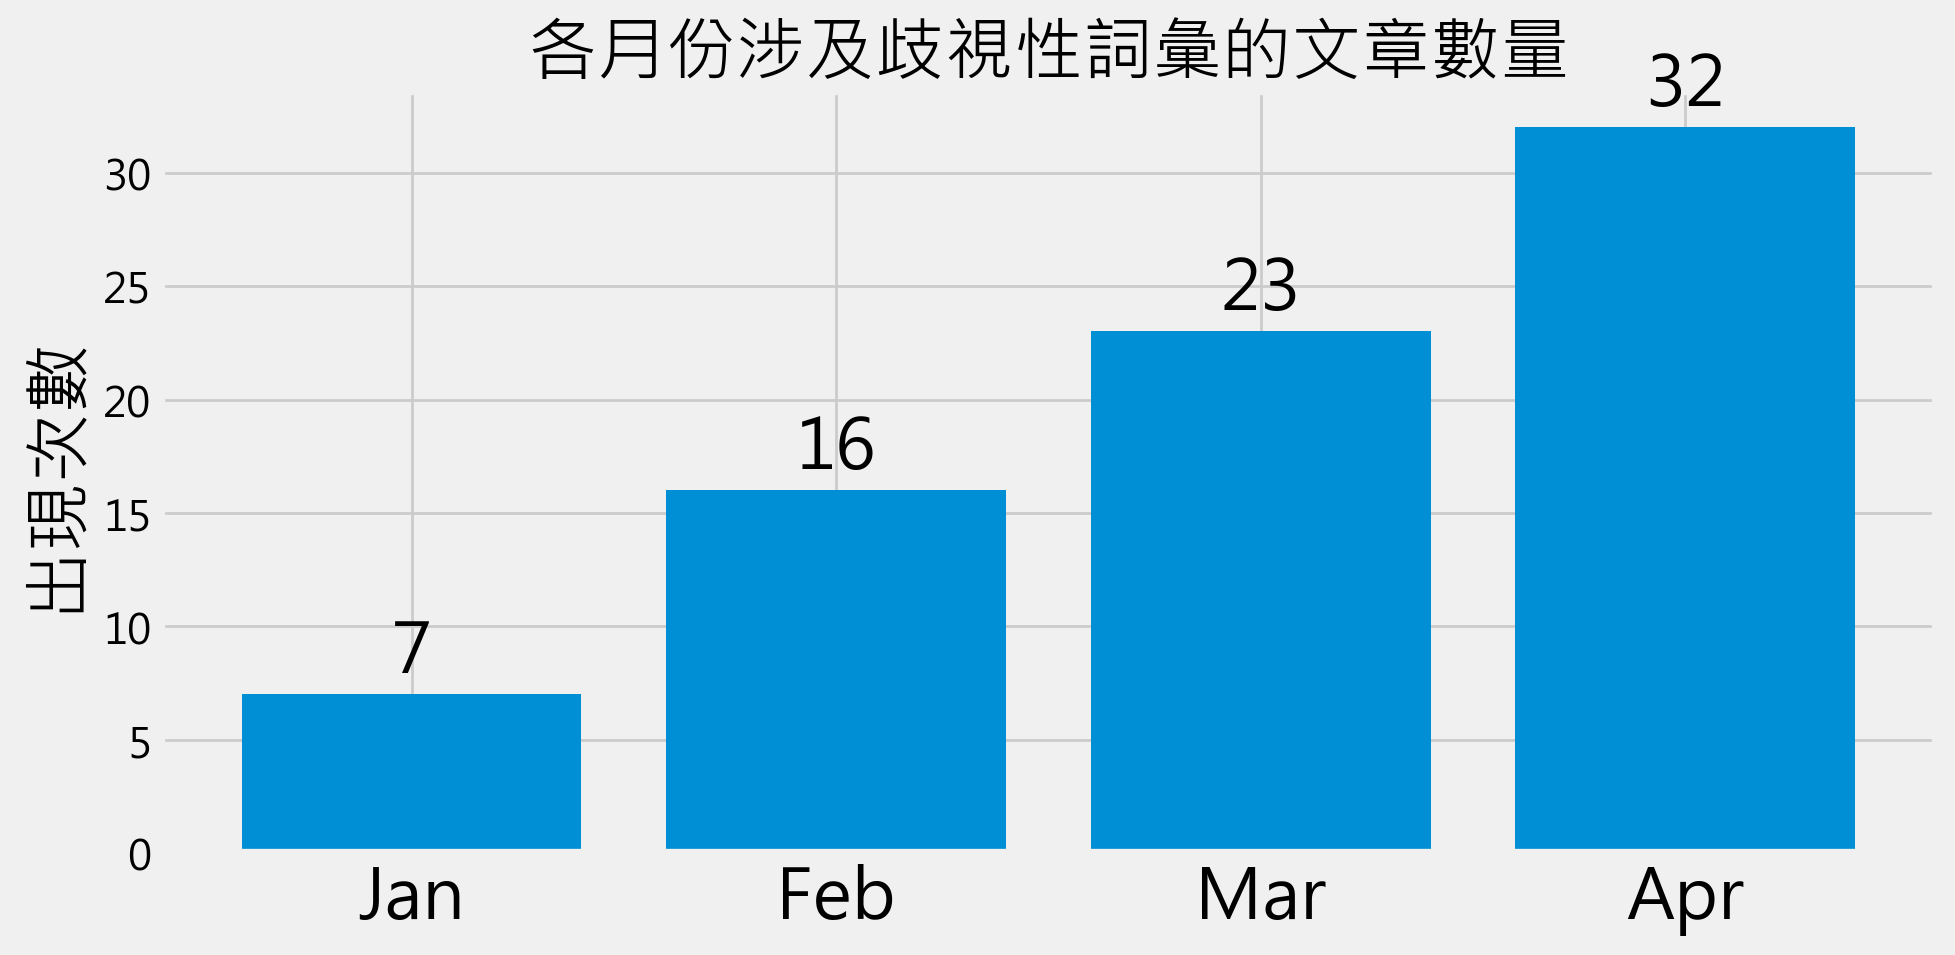

In [70]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
plt.title("各月份涉及歧視性詞彙的文章數量", fontsize=25)
rect = plt.bar(['Jan', 'Feb', 'Mar', 'Apr'], cont)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2, height+1.0, "%s" % int(height), fontsize=25, 
                 horizontalalignment='center')   
autolabel(rect)
plt.xticks(size=25)
plt.yticks(size=15)
plt.ylabel('出現次數', fontsize=25)
plt.tight_layout()
plt.savefig('Result/%s.png'%"各月份涉及歧視性詞彙的文章數量", dpi=300)
plt.show()